<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/CNNDenoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network Denoising for Medical Images
---
This notebook demonstrates the application of deep convolutional neural networks (CNNs) for reducing noise. By leveraging the prior information contained in many examples of low-noise and high-noise images, CNN denoising can reduce noise in CT images while maintaining high levels of anatomic detail.

This tutorial presents a simple overview of the training procedure for illustrative purposes, and is not intended to produce an optimal result. Modern metods based on GANs generally produce superior results..

In [1]:
#Cell 1

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow import keras
from scipy import ndimage, misc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import time
import os


Instructions for updating:
non-resource variables are not supported in the long term


## Loading Data

In order to train the CNN, we need many examples of low-noise and high-noise images. We must also be careful to evaluate the denoising performance on different images than those used for training. This can be done by partitioning the data into **training** examples, which are used to optimize the CNN parameters, **validation** examples, which are used to monitor the optimization process, and **testing** examples, which are used to check performance.

The data used in this tutorial is made available through the AAPM and Mayo Clinic Low Dose CT Grand Challenge (Medical Physics 44(10), 2017). Each training example consists of a pair of images: the input, which is a simulated 25% dose CT image, and the target, which is the corresponding routine dose CT image.

![alt text](https://drive.google.com/uc?id=1dBzBOk1ZejqZ8as9cioyXB--8X0z0SST)



In [2]:
#Cell 2
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70' -O ./Denoising_Data.zip
!unzip -q "./Denoising_Data.zip"


--2023-01-23 15:18:32--  https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70
Resolving docs.google.com (docs.google.com)... 142.250.4.101, 142.250.4.102, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0e6adk84mtmetn1js1avd7sairk3hvti/1674487050000/16160187475894979440/*/1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70?e=download&uuid=665543c5-60fb-42c9-b680-be60974e0303 [following]
--2023-01-23 15:18:44--  https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0e6adk84mtmetn1js1avd7sairk3hvti/1674487050000/16160187475894979440/*/1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70?e=download&uuid=665543c5-60fb-42c9-b680-be60974e0303
Resolving doc-00-60-docs.googleusercontent.com (doc-00-60-docs.googleusercontent.com)... 172.217.194.132, 2404:6800:400

In [3]:
#Cell 3

# 2000 30x30 image patches from 8 patients
train_input = np.load('./Denoising_Data/train_input.npy')
train_target = np.load('./Denoising_Data/train_target.npy')

# 1000 30x30 image patches from 1 patient
val_input = np.load('./Denoising_Data/val_input.npy')
val_target = np.load('./Denoising_Data/val_target.npy')


# 5 512x512 images from 1 patient
test_input = np.load('./Denoising_Data/test_input.npy')
test_target = np.load('./Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load('./Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


In [4]:
#Cell 4

# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):

  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

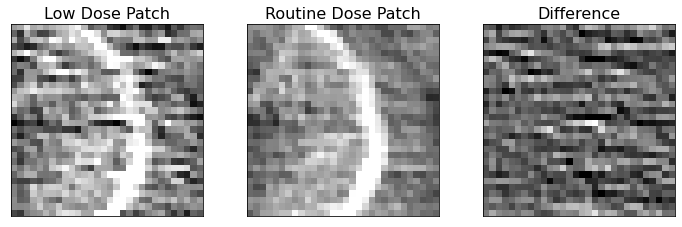

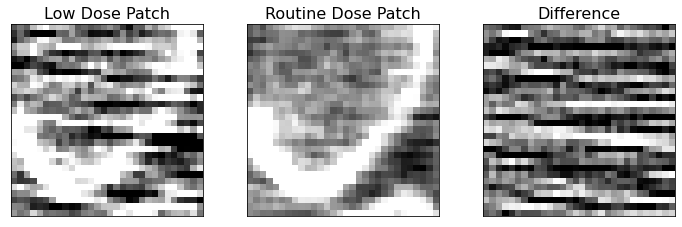

In [5]:
#Cell 5

# Get a few examples of training patches
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)



## Building the model:

We will employ a basic model for CNN denoising containing convolutional layers and ReLU activation layers as shown here: 

![](https://drive.google.com/uc?id=1wVJJ1olpxpXSFo32bbFjUZhjHW4uUiiF)



In [6]:
#Cell 6

# CNN properties
n_layers = 6 
filters = 64 
kernel_size = (3, 3)
strides = (1, 1) 
activation = 'relu'

# This function builds the model according to the parameters set above
# this uses keras, which is an older framework, but nicely shows how to build the CNN
def build_model():
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)
    
    # This loop adds each convolutional layer
    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)

    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model

denoising_model = build_model()
denoising_model.summary()

Model: "CT_denoiser"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_CT_images (InputLayer  [(None, None, None, 1)]  0         
 )                                                               
                                                                 
 normalization (Lambda)      (None, None, None, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 activation (Activation)     (None, None, None, 64)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 activation_1 (Activation)   (None, None, None, 64)    0         
                                                       

## Optimization: Training the network

It is worth noting that this denoising task is ill-posed. We should not expect to reconstruct the signal exactly, but we can make a prediction that agrees with the observed noisy data and prior knowledge. During optimization, we aim to have the CNN encode meaningful prior knowledge from many training examples into the predictions.

The CNN parameters will be optimized with one goal in mind: to minimize the mean-squared-error (MSE) difference between the CNN output images and the low-noise target images.


In [7]:
#Cell 7

# Training properties
epochs = 15 
batch_size = 32        
learning_rate = 0.0001  
optimizer = keras.optimizers.Adam(lr=learning_rate)

progress_example = 2
buffer = 128
progress_ims = []

def train(loss_function, model):
    model.compile(optimizer=optimizer, loss=loss_function)

    # As the training progresses, we'll save the images at each stage
    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):  
      val_loss = model.evaluate(val_input, val_target)
      example_output = model.predict(example_input)
      example_img = example_output[0, edge_buffer:-edge_buffer,
                                edge_buffer:-edge_buffer, 0]
      progress_ims.append(example_img)
      progress_val.append(val_loss)
    
      istart = 0
      while istart < (len(train_input) - batch_size):
          x = train_input[istart:istart + batch_size]
          y = train_target[istart:istart + batch_size]
          model.train_on_batch(x=x, y=y)
          istart += batch_size

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val


# Train the model
denoising_model, progress_ims, progress_val = train(loss_function='mse', model=denoising_model)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training phase complete.


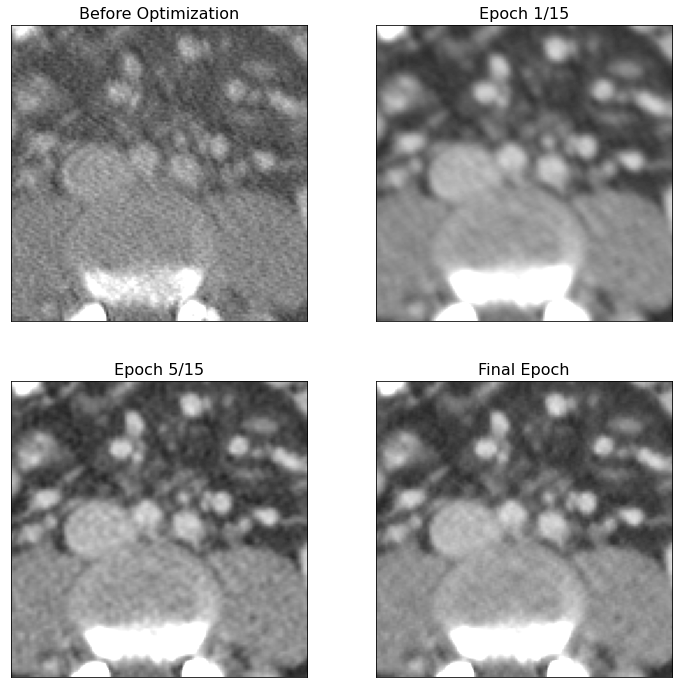

In [8]:
#Cell 8

# Show some example images

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title('Before Optimization', fontsize=16)
ctshow(progress_ims[0, :, :], window='variable')

plt.subplot(2, 2, 2)
plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
ctshow(progress_ims[1, :, :], window='soft_tissue')

plt.subplot(2, 2, 3)
plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
ctshow(progress_ims[5, :, :], window='soft_tissue')

plt.subplot(2, 2, 4)
plt.title('Final Epoch', fontsize=16)
ctshow(progress_ims[-1, :, :], window='soft_tissue')

### Inference: Testing the network

Now that the network is fully trained, we can apply to our CNN in inference mode to the reserved testing data to check the performance. Since all CNN parameters are fixed at this point, the processing time for this phase is typically very fast.

Here we include a comparison with a Gaussian smoothing filter. Notice that the CNN is able to better maintain feature resolution relative to the Gaussian filter. The improvment is most notable at high contrast boundaries.





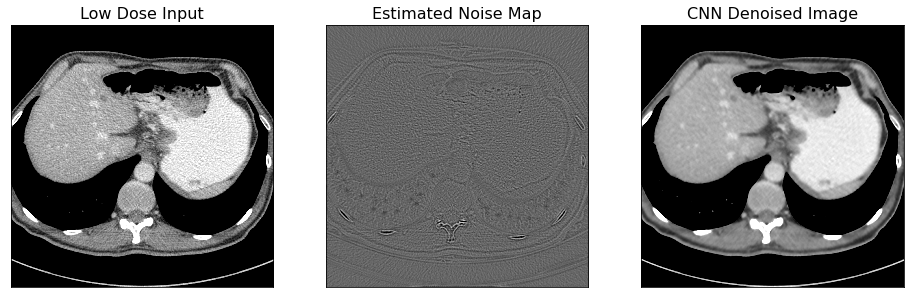

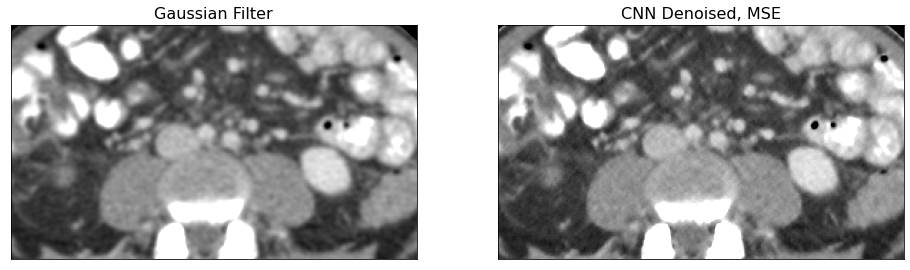

In [9]:
#Cell 9

# Display an example input image, the denoised image, and the difference
nexample = 1
CNNout = denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])

plt.subplot(1, 3, 2)
plt.title('Estimated Noise Map', fontsize=16)
ctshow(test_input[nexample, :, :, 0] - CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('CNN Denoised Image', fontsize=16)
ctshow(CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Gaussian Filter', fontsize=16)
gaussfilt = ndimage.gaussian_filter(test_input[3, :, :, 0], sigma=1.4)
ctshow(gaussfilt[110:-110, 50:-50])

plt.subplot(1, 2, 2)
plt.title('CNN Denoised, MSE', fontsize=16)
ctshow(CNNout[3, 110:-110, 50:-50, 0])



## Feature loss using VGG16:

The choice of loss function has a substantial impact on the denoising result. Our initial MSE loss function is a pixel-per-pixel comparison between the denoised image and the routine-dose reference. In order to develop a metric that better corresponds to image quality, this loss function may be supplemented by metrics that perform non-local comparisons of image features. One such approach is feature loss, which computes the MSE between feature maps of a pre-trained image classification network. Here we demonstrate this loss using the VGG16 network trained on ImageNet data. 


![alt text](https://drive.google.com/uc?id=1tYPdT-o4VFKK2q9aJ0F7tNZhBc3f5SOx)


In [10]:
#Cell 10

# Load the pre-trained VGG model from Keras
modelVGG = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, pooling=None)
modelVGG.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [11]:
#Cell 11

# Here we select the layers we will use to use to define the feature loss 
# Then we build a model that outputs the feature maps of these layers
feature_loss_layers = [
    'block3_conv3'
]

def get_VGG_features(feature_layers):

  # VGG expects normalized inputs, so we need to do some preprocessing to the CT
  # images first
  stack_layer = keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3]), name='CT_stack')
  preproc_layer = keras.layers.Lambda(lambda x: (x + 1024.0)/1500., name='CT_preprocess')
  clip_layer = keras.layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0), name='CT_clip')

  # Get VGG input and add preprocesing layers
  inputs = keras.layers.Input(shape=(None, None, 1))
  x = stack_layer(inputs)
  x = preproc_layer(x)
  x = clip_layer(x)

  # Re-connect subsequent layers, and add to output if layer was specified
  # for feature loss
  outputs = []
  for layer in modelVGG.layers[1:]:
    x = layer(x)
    if layer.name in feature_loss_layers:
      print('Adding layer {} to output'.format(layer.name))
      outputs.append(x)

  vgg_feature_model = keras.Model(inputs, outputs)
  return vgg_feature_model

feature_model = get_VGG_features(feature_loss_layers)
feature_model.trainable = False
feature_model.summary()

Adding layer block3_conv3 to output
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 CT_stack (Lambda)           (None, None, None, 3)     0         
                                                                 
 CT_preprocess (Lambda)      (None, None, None, 3)     0         
                                                                 
 CT_clip (Lambda)            (None, None, None, 3)     0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2

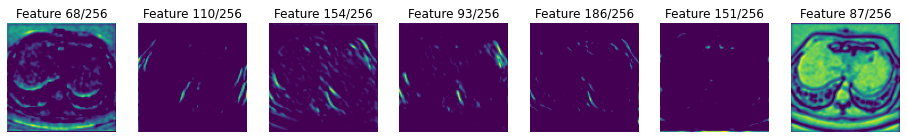

In [12]:
#Cell 13

# Run an example CT image through VGG model and plot a random selection of 
# feature maps
y = feature_model.predict(test_input[[1]])
plt.figure(figsize=(16, 9))
nexamples = 7

for i in range(nexamples):
  plt.subplot(1, nexamples, i+1)
  ifeature = np.random.choice(256, replace=False)
  plt.axis('off')
  plt.title('Feature {}/256'.format(ifeature))
  plt.imshow(y[0, :, :, ifeature])


In [13]:
#Cell 14

# Now we use the feature model to build a loss function that compares the VGG
# features between the CNN-denoised output (y_pred) and the routine-dose 
# reference (y_true).
def build_feature_loss(feature_extractor, mse_scale=0.01):
  
  def vgg_feature_loss(y_true, y_pred):

    # extract features and compute feature loss
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)

    if type(y_true_features) == list:
      feat_loss = 0.0
      for itrue, ipred in zip(y_true_features, y_pred_features):
        feat_loss += tf.reduce_mean(tf.square(itrue - ipred))
    else:
      feat_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))

    # also compute pixel-wise MSE loss
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    total_loss = feat_loss + (mse_scale * mse_loss)
      
    return total_loss

  return vgg_feature_loss

feature_loss = build_feature_loss(feature_model)

In [14]:
#Cell 15

# Build a new denoising model (same architcture as before!), 
# and optimize the weights using feature loss
model_vggloss = build_model()
model_vggloss.summary()


Model: "CT_denoiser"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_CT_images (InputLayer  [(None, None, None, 1)]  0         
 )                                                               
                                                                 
 normalization (Lambda)      (None, None, None, 1)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 64)    640       
                                                                 
 activation_5 (Activation)   (None, None, None, 64)    0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 activation_6 (Activation)   (None, None, None, 64)    0         
                                                       

In [15]:
#Cell 16

model_vggloss, progress_ims, progress_val = train(loss_function=feature_loss, model=model_vggloss)

Training phase complete.


### Inference: Comparing the loss functions

Now the model has been optimized with two different loss functions.
Next we compare their ability to reduce noise while maintaining resolution of anatomic features. 
In order to assess the accuracy of CNN denoising we often visually compare the CNN denoised low dose images to the routine dose image. To assess the ability to maintain resolution we often use line profiles.

The MSE loss function had more extensive noise reduction. The feature loss function was able to better maintain CT texture in the image. Both loss functions had similar ability to retain resolution at a high contrast interface. Altering the loss function has a large impact on CNN denoising performance.

The Gaussian smoothing filter is again provided for comparison. Observe how the CNN denoised image with feature loss was able to fine structures much better than the Gaussain smoothing filter. 

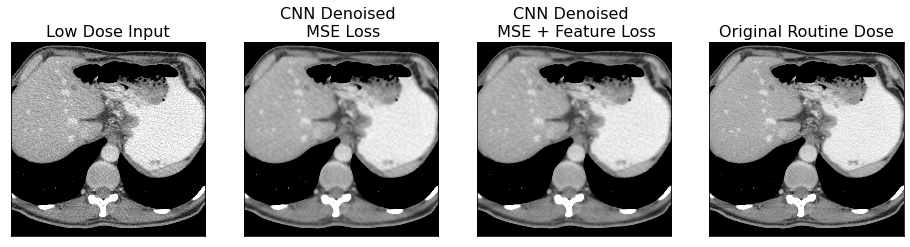

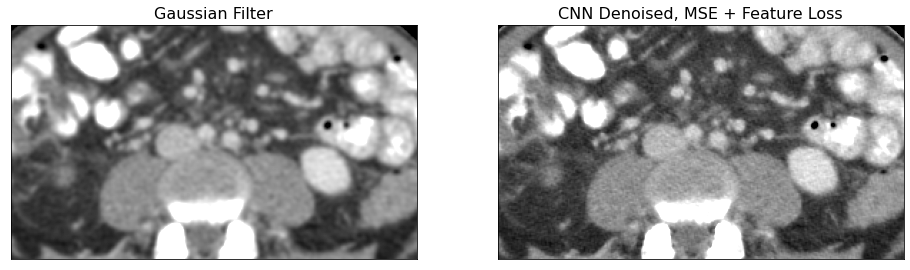

In [16]:
#Cell 17

# Run models on reserved testing data
CNNout_mseloss = denoising_model.predict(test_input)
CNNout_vggloss = model_vggloss.predict(test_input)

# Plot for visual inspection of image quality
buffer = 32
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 2)
plt.title('CNN Denoised \n MSE Loss', fontsize=16)
ctshow(CNNout_mseloss[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 3)
plt.title('CNN Denoised \n MSE + Feature Loss', fontsize=16)
ctshow(CNNout_vggloss[1, buffer:-buffer, buffer:-buffer, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[1, buffer:-buffer, buffer:-buffer, 0])

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Gaussian Filter', fontsize=16)
gaussfilt = ndimage.gaussian_filter(test_input[3, :, :, 0], sigma=1.4)
ctshow(gaussfilt[110:-110, 50:-50])

plt.subplot(1, 2, 2)
plt.title('CNN Denoised, MSE + Feature Loss', fontsize=16)
ctshow(CNNout_vggloss[3, 110:-110, 50:-50, 0])

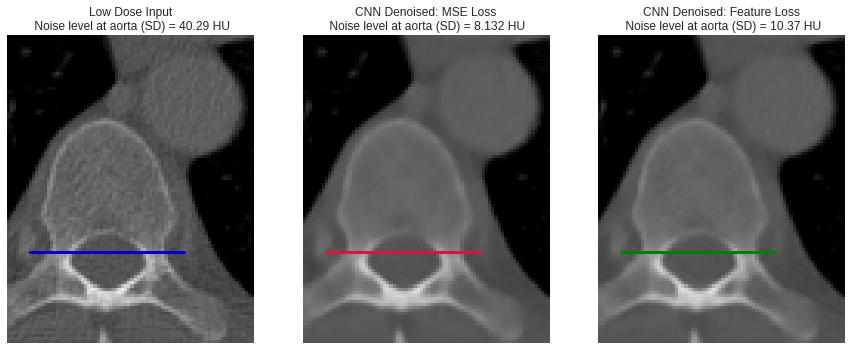

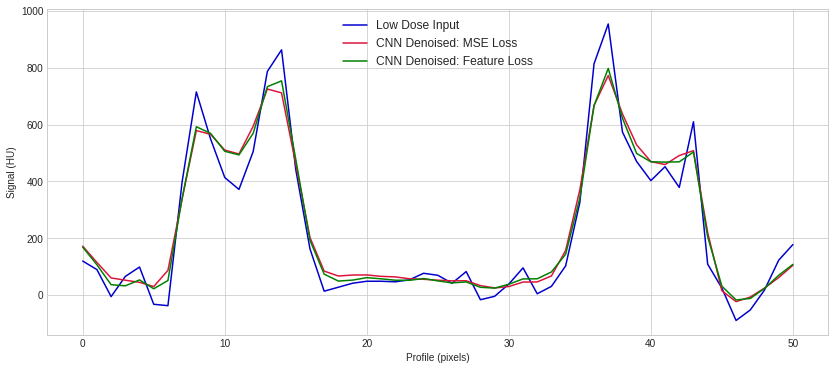

In [17]:
#High contrast resolution evaluation:
CNNout_mseloss = denoising_model.predict(test_input)
CNNout_vggloss = model_vggloss.predict(test_input)

# Standard deviation noise in approximately uniform region (aorta)
std_in = test_input[0, 222:237, 203:218, 0].std()
std_cnn_mse = CNNout_mseloss[0, 222:237, 203:218, 0].std()
std_cnn_vgg = CNNout_vggloss[0, 222:237, 203:218, 0].std()
style.use('seaborn-white') 

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Low Dose Input\n Noise level at aorta (SD) = %.4g HU' % std_in, fontsize=12)
ctshow(test_input[0, 207:307, 151:231, 0], window='bone')
plt.plot([7, 57], [70, 70], 'mediumblue', lw=3)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('CNN Denoised: MSE Loss\n Noise level at aorta (SD) = %.4g HU' % std_cnn_mse, fontsize=12)
ctshow(CNNout_mseloss[0, 207:307, 151:231, 0], window='bone')
plt.plot([7, 57], [70, 70], 'crimson', lw=3)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('CNN Denoised: Feature Loss\n Noise level at aorta (SD) = %.4g HU' % std_cnn_vgg, fontsize=12)
ctshow(CNNout_vggloss[0, 207:307, 151:231, 0], window='bone')
plt.plot([7, 57], [70, 70], 'green', lw=3)
plt.axis('off')
plt.show()

# Line profile comparison
style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 6))
plt.plot(test_input[0, 276, 158:209, 0], label="Low Dose Input",color='mediumblue')
plt.plot(CNNout_mseloss[0, 276, 158:209, 0], label="CNN Denoised: MSE Loss",color='crimson')
plt.plot(CNNout_vggloss[0, 276, 158:209, 0], label="CNN Denoised: Feature Loss",color='green')
plt.xlabel('Profile (pixels)')
plt.ylabel('Signal (HU)')
plt.legend(loc='upper center', fontsize = 12)
plt.show()

## Discussion

The results here are for illustrative purposes only and are not intended to produce state-of-the-art results. As such, the denoised images above contain numerous artifacts which may interfere with the diagnostic quality. Modern denoising methods typically employ GANs. 


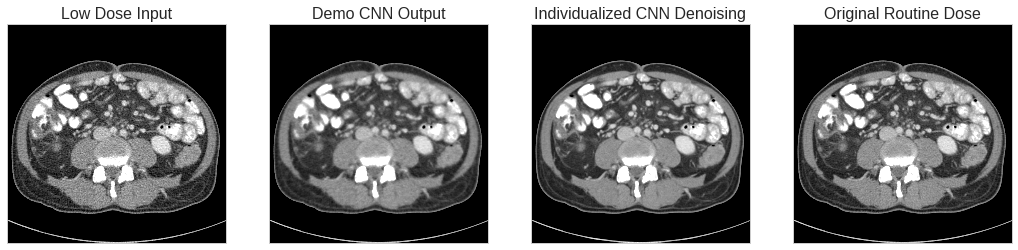

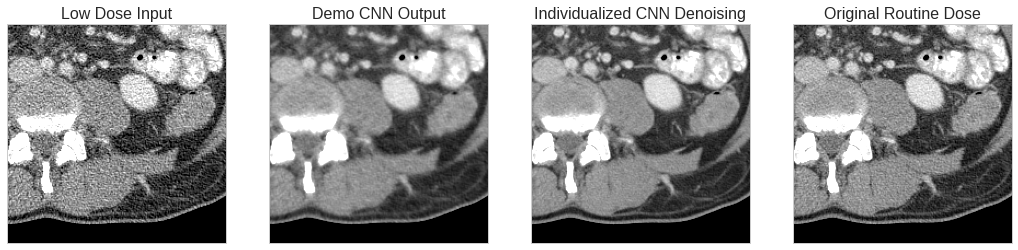

In [18]:
#Cell 18

# Load full quarter dose test image and display result
nexample = 3  

window_width = 400
window_level = 40
vmin = window_level - window_width // 2
vmax = window_level + window_width // 2

plt.figure(figsize=(18, 8))
plt.subplot(1, 4, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])

plt.subplot(1, 4, 2)
plt.title('Demo CNN Output', fontsize=16)
ctshow(CNNout_vggloss[nexample, :, :, 0])

# These are some examples from an individually-tuned CNN.
# These results were presented in at the 2019 RSNA Annual Meeting
# (Missert, et al. "Patient-Specific Noise Reduction Using a Deep Convolutional Neural Network" (SSE24-02))
plt.subplot(1, 4, 3)
plt.title("Individualized CNN Denoising", fontsize=16)
ctshow(test_example[nexample, :, :, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[nexample, :, :, 0])

# Same as above, but zoomed in to see more details
plt.figure(figsize=(18, 8))
plt.subplot(1, 4, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 2)
plt.title('Demo CNN Output', fontsize=16)
ctshow(CNNout_vggloss[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 3)
plt.title('Individualized CNN Denoising', fontsize=16)
ctshow(test_example[nexample, 150:350, 150:350, 0])

plt.subplot(1, 4, 4)
plt.title('Original Routine Dose', fontsize=16)
ctshow(test_target[nexample, 150:350, 150:350, 0])

plt.show()

We acknowledge Dr. Cynthia McCollough, the Mayo Clinic, the American Association of Physicists in Medicine, and grants EB017095 and EB017185 from the National Institute of Biomedical Imaging and Bioengineering for distributing the data used within this publication.